<a href="https://colab.research.google.com/github/hannadania/BizarreBazaarSystem/blob/main/Airline_Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_csv("Tweets.csv")  # Update path if needed
print(df.columns)  # Check available columns


Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


In [3]:
# Keep only necessary columns
df = df[['airline_sentiment', 'text']]
print(df.head())  # Check if it works


  airline_sentiment                                               text
0           neutral                @VirginAmerica What @dhepburn said.
1          positive  @VirginAmerica plus you've added commercials t...
2           neutral  @VirginAmerica I didn't today... Must mean I n...
3          negative  @VirginAmerica it's really aggressive to blast...
4          negative  @VirginAmerica and it's a really big bad thing...


In [4]:
### Data preprocessing (clean tweets for ML)

import re
import nltk
from nltk.corpus import stopwords # List of common words

nltk.download("stopwords") # Downloads common words
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove links
    text = re.sub(r'\@w+|\#', "", text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', "", text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,clean_text
0,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercials exp...
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...
3,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


<ipython-input-5-167a20908d67>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="airline_sentiment", data=df, palette="coolwarm")


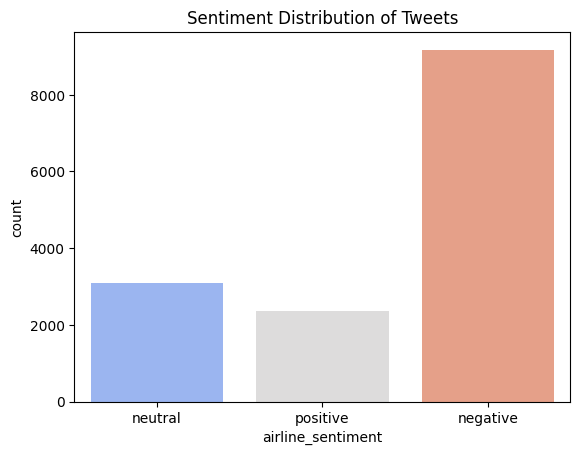

In [5]:
## EDA & visualisation. Below is sentiment distribution

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="airline_sentiment", data=df, palette="coolwarm")
plt.title("Sentiment Distribution of Tweets")
plt.show()


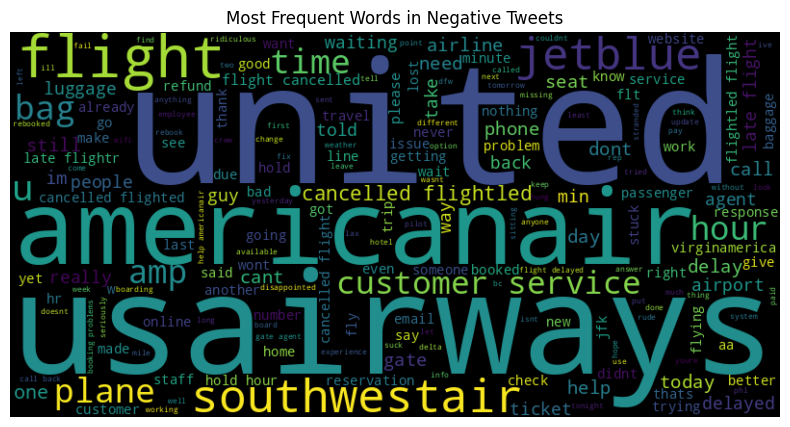

In [6]:
## EDA & visualisation. Below is most frequent words in negative tweets

from wordcloud import WordCloud

negative_tweets = " ".join(df[df["airline_sentiment"] == "negative"]["clean_text"])
wordcloud = WordCloud(width=800, height=400).generate(negative_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Tweets")
plt.show()


In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Keep only necessary columns
df = df[['airline_sentiment', 'text']]

# Convert labels (negative=0, neutral=1, positive=2)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['airline_sentiment'].map(label_map)

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Convert text into numerical features with a max of 5000 features
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['sentiment']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 80.50%


In [9]:
def predict_sentiment(text):
    cleaned_text = clean_text(text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)[0]

    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[prediction]

# Test with example tweets
print(predict_sentiment("I love this airline! Good service."))
print(predict_sentiment("Flight was delayed for hours. Terrible experience."))


Positive
Negative
